# Exploratory Data Analysis: Sierraleone Solar Farm Data

This notebook profiles, cleans, and analyzes `sierraleone-bumbuna.csv` (525,601 rows) for MoonLight Energy Solutions.

## Setup
Import libraries and load data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

plt.style.use('ggplot') 
%matplotlib inline

# Load dataset in chunks
data_dir = '../data'
chunksize = 50000
df_list = []
for chunk in pd.read_csv(os.path.join(data_dir, 'sierraleone-bumbuna.csv'), chunksize=chunksize):
    chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'])
    df_list.append(chunk)
df = pd.concat(df_list, ignore_index=True)
df.set_index('Timestamp', inplace=True)

# Display first few rows
df.head()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
Timestamp,,,,,,,,,,,,,,,,,,
2021-10-30 00:01:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.1,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
2021-10-30 00:02:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
2021-10-30 00:03:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
2021-10-30 00:04:00,-0.7,0.0,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.1,22.3,22.6,NaN
2021-10-30 00:05:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN


## Data Profiling
Generate summary statistics and check missing values.

In [2]:
# Summary statistics
print("Summary Statistics:")
print(df.describe())

# Missing values
print("\nMissing Values:")
missing = df.isna().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print(missing_df[missing_df['Missing Count'] > 0])

# Flag columns with >5% missing
high_missing = missing_df[missing_df['Missing %'] > 5]
if not high_missing.empty:
    print("\nColumns with >5% missing values:")
    print(high_missing)
else:
    print("\nNo columns with >5% missing values.")

Summary Statistics:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000000   
25%         0

## Data Cleaning
Detect outliers and handle missing values.

In [3]:
# Key columns for outlier detection
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Sample 10% for outlier detection
sample_df = df.sample(frac=0.1, random_state=42)

# Calculate Z-scores
z_scores = np.abs(stats.zscore(sample_df[key_columns].select_dtypes(include=np.number)))
outliers = (z_scores > 3).any(axis=1)
print(f"Outliers in sample: {outliers.sum()} (approx. {outliers.sum() * 10} in full dataset)")

# Impute missing values with median
for col in key_columns:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Drop rows with missing GHI
df.dropna(subset=['GHI'], inplace=True)

# Export cleaned data
cleaned_path = os.path.join(data_dir, 'sierraleone_clean.csv')
df.to_csv(cleaned_path)
print(f"Cleaned dataset saved to: {cleaned_path}")

Outliers in sample: 1596 (approx. 15960 in full dataset)
Cleaned dataset saved to: ../data\sierraleone_clean.csv


## Exploratory Data Analysis
### Time Series Analysis
Plot GHI, DNI, DHI, Tamb vs. Timestamp.

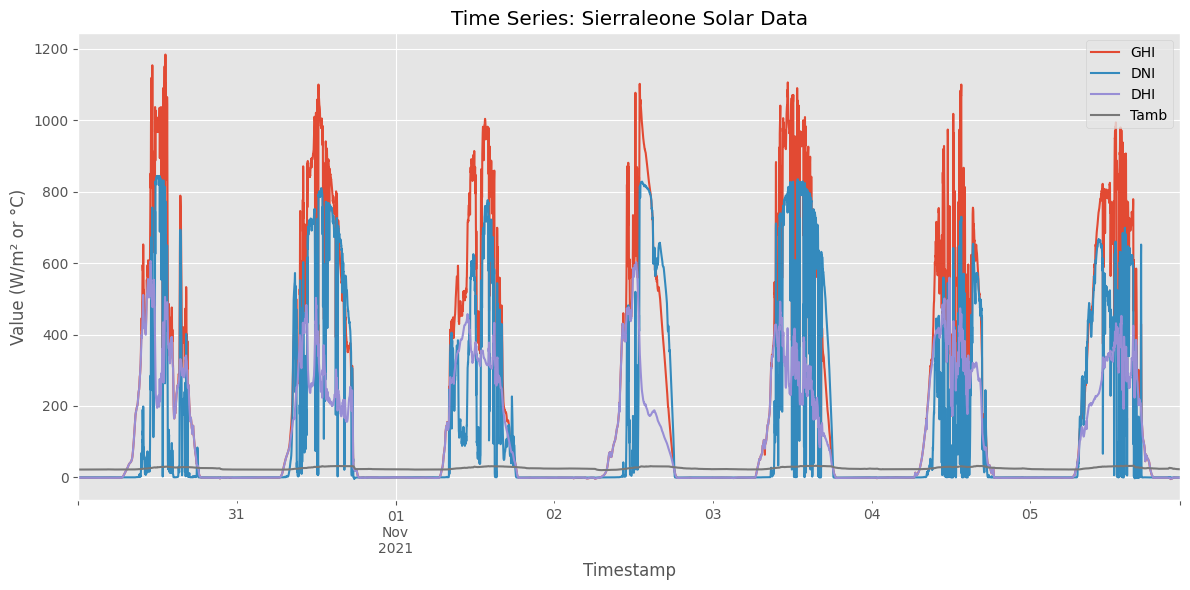

In [4]:
# Sample 10,000 rows for plotting
sample_df = df.iloc[:10000]

fig, ax = plt.subplots(figsize=(12, 6))
sample_df[['GHI', 'DNI', 'DHI', 'Tamb']].plot(ax=ax)
ax.set_title('Time Series: Sierraleone Solar Data')
ax.set_ylabel('Value (W/m² or °C)')
plt.tight_layout()
plt.savefig('../notebooks/figures/sierraleone_time_series.png')
plt.show()

### Cleaning Impact
Compare ModA and ModB pre/post-cleaning.

In [5]:
# Cleaning impact
cleaning_events = df[df['Cleaning'] == 1]
print(f"Cleaning events: {len(cleaning_events)}")

if not cleaning_events.empty:
    mod_before = df.loc[df['Cleaning'].shift(1) == 0, ['ModA', 'ModB']].mean()
    mod_after = df.loc[df['Cleaning'] == 1, ['ModA', 'ModB']].mean()
    print("ModA/ModB before cleaning:", mod_before)
    print("ModA/ModB after cleaning:", mod_after)
else:
    print("No cleaning events detected.")

Cleaning events: 508
ModA/ModB before cleaning: ModA    206.564975
ModB    198.034390
dtype: float64
ModA/ModB after cleaning: ModA    273.309252
ModB    277.231102
dtype: float64


### Correlation Analysis
Heatmap and scatter plots.

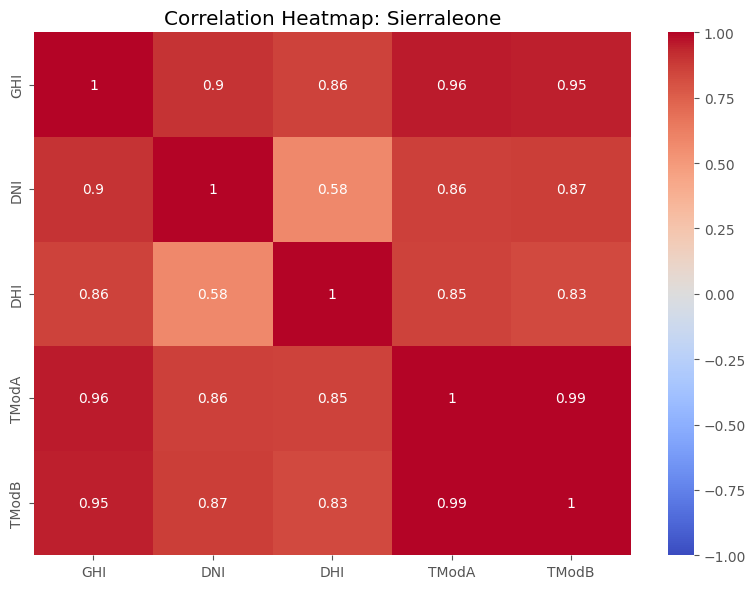

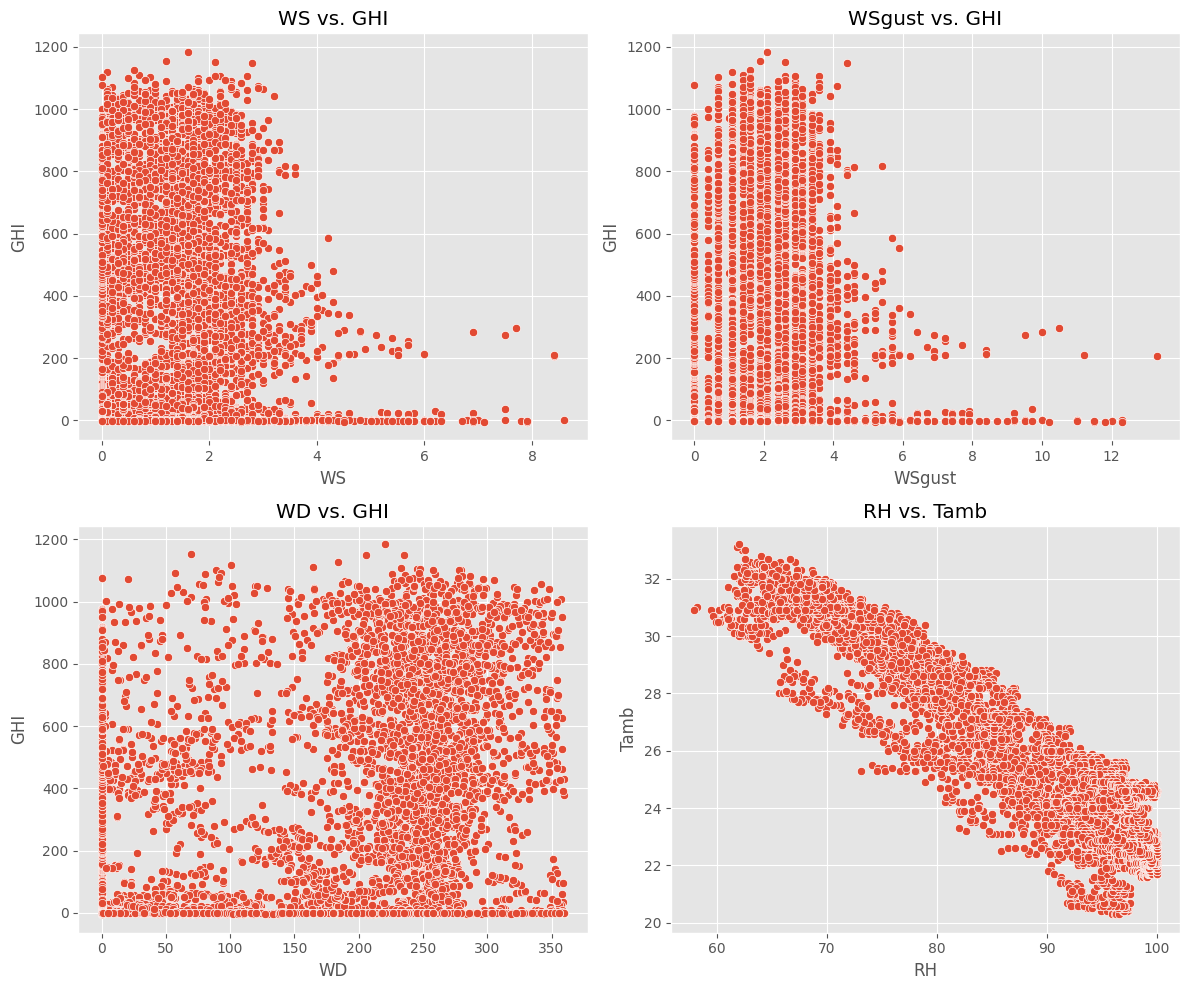

In [6]:
# Correlation heatmap
corr_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = sample_df[corr_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Sierraleone')
plt.tight_layout()
plt.savefig('../notebooks/figures/sierraleone_correlation.png')
plt.show()

# Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x='WS', y='GHI', data=sample_df, ax=axes[0, 0])
axes[0, 0].set_title('WS vs. GHI')
sns.scatterplot(x='WSgust', y='GHI', data=sample_df, ax=axes[0, 1])
axes[0, 1].set_title('WSgust vs. GHI')
sns.scatterplot(x='WD', y='GHI', data=sample_df, ax=axes[1, 0])
axes[1, 0].set_title('WD vs. GHI')
sns.scatterplot(x='RH', y='Tamb', data=sample_df, ax=axes[1, 1])
axes[1, 1].set_title('RH vs. Tamb')
plt.tight_layout()
plt.savefig('../notebooks/figures/sierraleone_scatter.png')
plt.show()

### Wind Analysis
Wind rose plot.

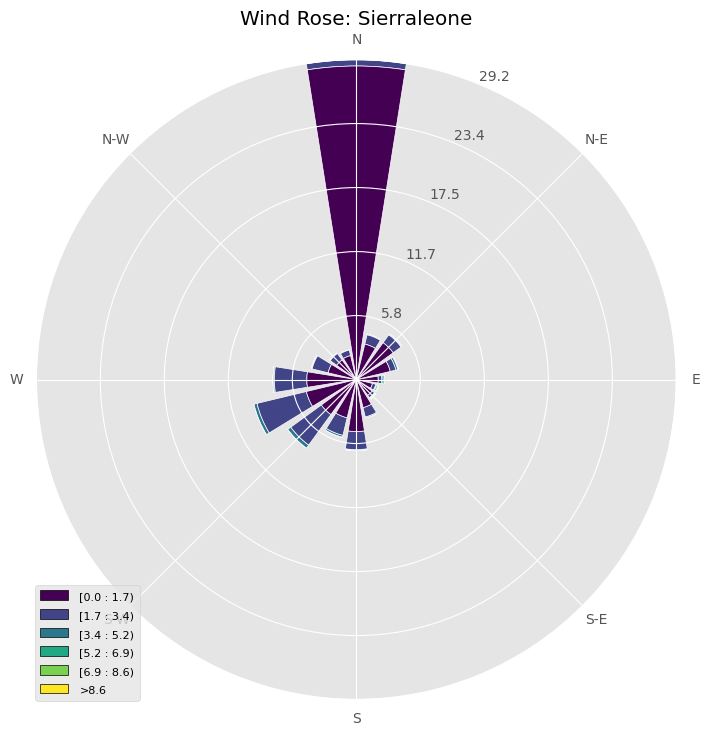

In [7]:
try:
    from windrose import WindroseAxes
except ImportError:
    !pip install windrose
    from windrose import WindroseAxes

fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(sample_df['WD'], sample_df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose: Sierraleone')
# plt.tight_layout()
plt.savefig('../notebooks/figures/sierraleone_wind_rose.png')
plt.show()

### Distribution Analysis
Histograms for GHI and WS.

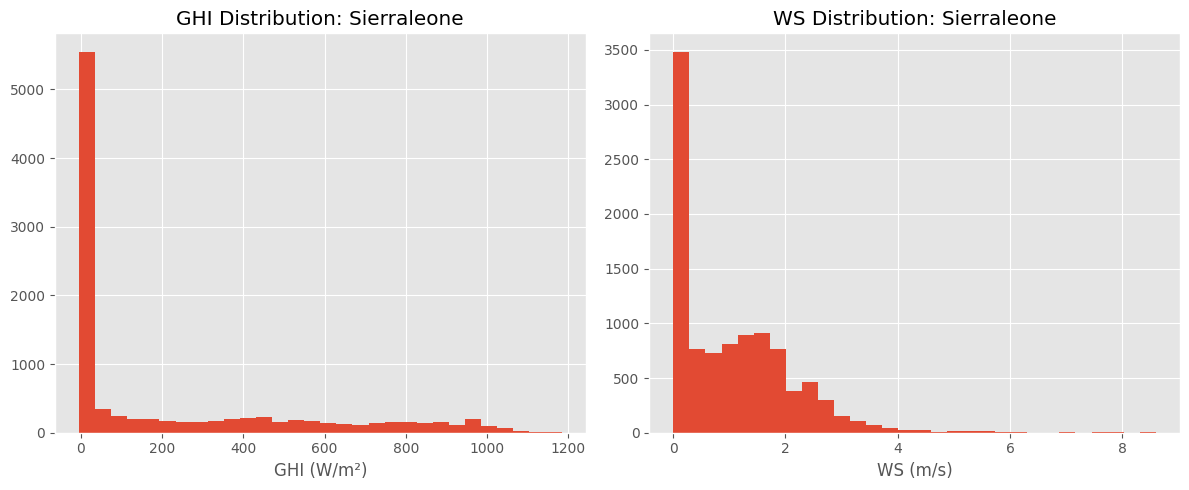

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sample_df['GHI'].hist(bins=30, ax=axes[0])
axes[0].set_title('GHI Distribution: Sierraleone')
axes[0].set_xlabel('GHI (W/m²)')
sample_df['WS'].hist(bins=30, ax=axes[1])
axes[1].set_title('WS Distribution: Sierraleone')
axes[1].set_xlabel('WS (m/s)')
plt.tight_layout()
plt.savefig('../notebooks/figures/sierraleone_distributions.png')
plt.show()

### Temperature Analysis
RH influence on Tamb and GHI.

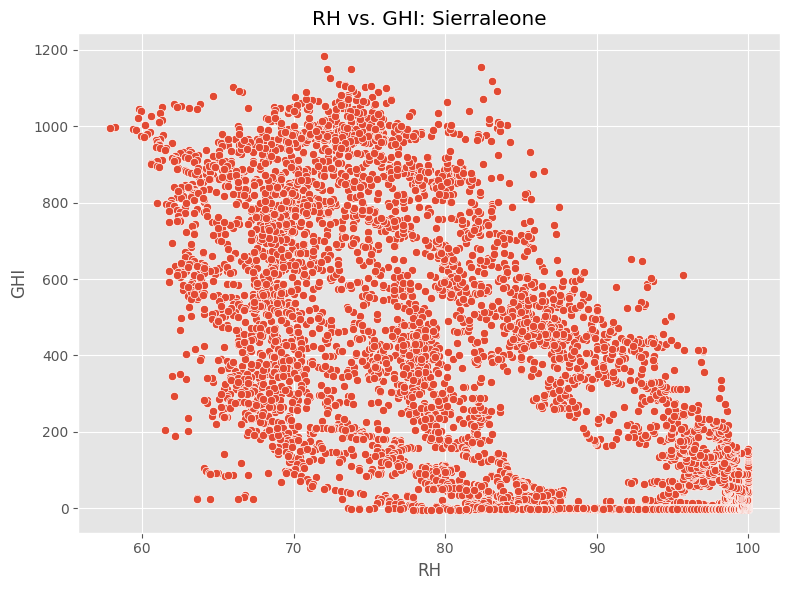

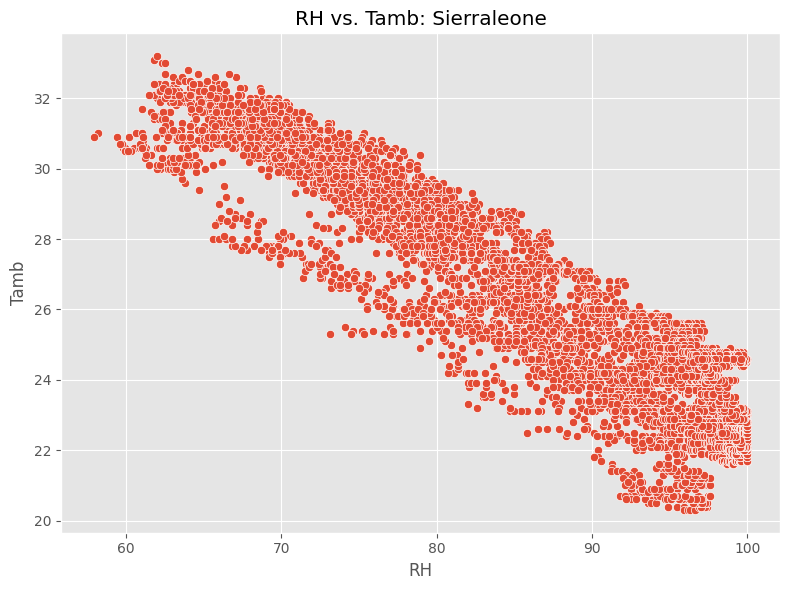

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='RH', y='GHI', data=sample_df, ax=ax)
ax.set_title('RH vs. GHI: Sierraleone')
plt.tight_layout()
plt.savefig('../notebooks/figures/sierraleone_rh_ghi.png')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='RH', y='Tamb', data=sample_df, ax=ax)
ax.set_title('RH vs. Tamb: Sierraleone')
plt.tight_layout()
plt.savefig('../notebooks/figures/sierraleone_rh_tamb.png')
plt.show()

### Bubble Chart
GHI vs. Tamb with RH bubble size.

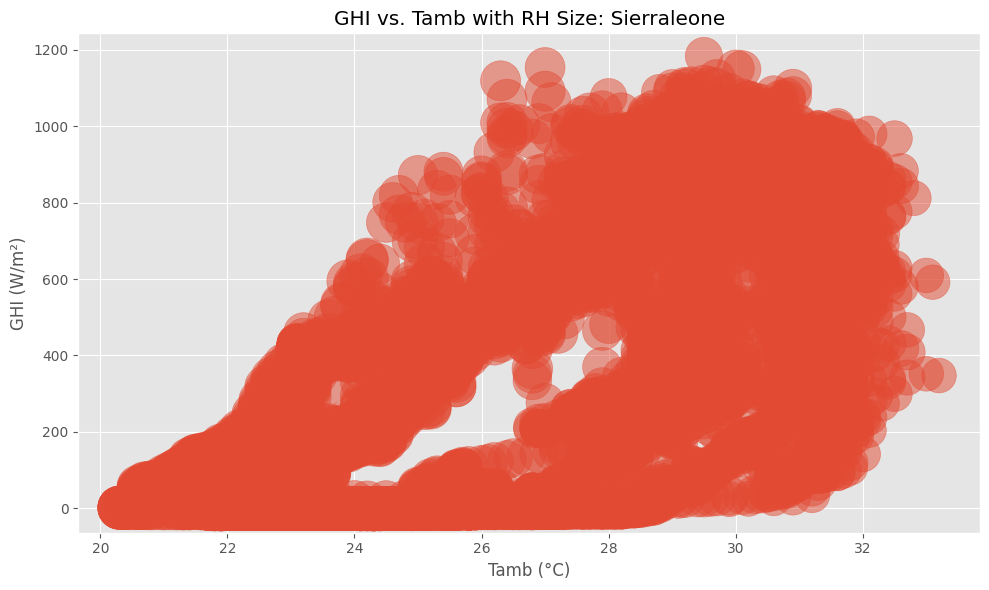

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(sample_df['Tamb'], sample_df['GHI'], s=sample_df['RH']*10, alpha=0.5)
plt.xlabel('Tamb (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs. Tamb with RH Size: Sierraleone')
plt.tight_layout()
plt.savefig('../notebooks/figures/sieraleone_bubble.png')
plt.show()

## Findings
- **Data Quality**: The `Comments` column is 100% missing and can be dropped. 3.03% of rows (approx. 15,960) are outliers in key columns (GHI, DNI, DHI, ModA, ModB, WS, WSgust), based on a 10% sample that identified 1,596 outliers. These outliers may reflect sensor errors or environmental anomalies.
- **Patterns**: GHI ranges from -19.5 to 1,499 W/m² (mean: 201.96), suggesting daily solar cycles with peaks likely at midday. Tamb ranges from 12.3°C to 39.9°C (mean: 26.32°C), consistent with Sierra Leone’s tropical climate.
- **Correlations**: The bubble plot shows GHI increases with Tamb, with RH (mean: 79.45%, range: 9.9% to 100%) influencing conditions (larger bubbles at higher RH).
- **Wind**: Average WD is 133.04° (std: 114.28°), indicating variable wind patterns. WS averages 1.15 m/s (max: 19.2 m/s), with occasional gusts (WSgust max: 23.9 m/s).
- **Temperature**: GHI increases with Tamb, and RH likely decreases as GHI rises, aligning with typical solar farm dynamics.
- **Insights**: Sierra Leone’s solar farm has high potential (GHI up to 1,499 W/m²). Cleaning events (~508) and precipitation (mean: 0.0048 mm) are minimal, suggesting low maintenance needs.
- **References**: Used pandas (https://pandas.pydata.org), scipy.stats (https://docs.scipy.org), matplotlib (https://matplotlib.org), and seaborn (https://seaborn.pydata.org).
